/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_37011/668039320.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sample = pd.read_sql(query, connection)


Natural outliers: 25525 / 100000 = 25.52%


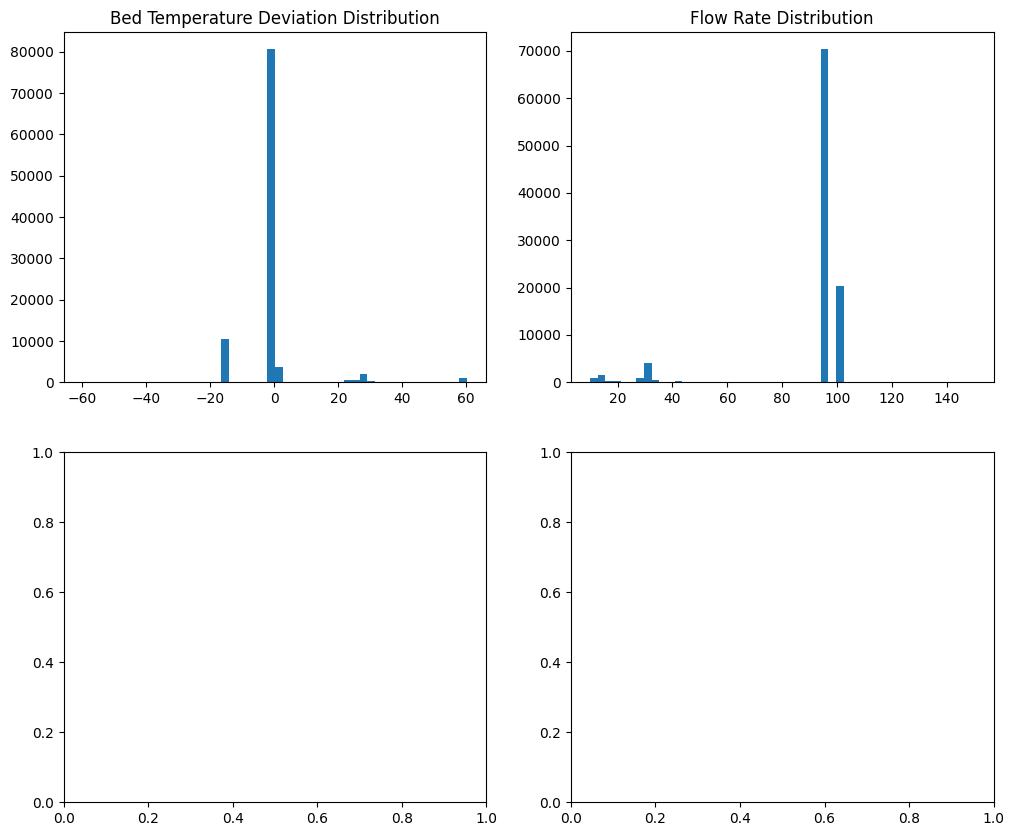

In [2]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pymysql

# Connect to database
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='admintushar15',
    database='printer_data_db'
)

# Sample 100K rows for exploration
query = """
SELECT * FROM PrinterData 
WHERE state = 'PRINTING'
ORDER BY RAND() 
LIMIT 100000
"""
df_sample = pd.read_sql(query, connection)

# Visualize normal vs abnormal patterns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Temperature deviations
axes[0,0].hist(df_sample['tempBed'] - df_sample['targetBed'], bins=50)
axes[0,0].set_title('Bed Temperature Deviation Distribution')

# Flow rates
axes[0,1].hist(df_sample['flow'], bins=50)
axes[0,1].set_title('Flow Rate Distribution')

# Identify natural outliers
Q1 = df_sample['tempNozzle'].quantile(0.25)
Q3 = df_sample['tempNozzle'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_sample[(df_sample['tempNozzle'] < Q1 - 1.5*IQR) | 
                      (df_sample['tempNozzle'] > Q3 + 1.5*IQR)]
print(f"Natural outliers: {len(outliers)} / {len(df_sample)} = {len(outliers)/len(df_sample)*100:.2f}%")

/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_37011/874335628.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


            printer_id   avg_temp  temp_variation   avg_flow   avg_speed
0  CZPX1522X017XC78087  57.362146        8.879548  77.951571   99.798312
1  CZPX1522X017XC78307  59.498698        3.637268  69.898470  100.000000
2  CZPX1622X017XC78384  53.834842       12.616029  84.877162  101.568880
3  CZPX1622X017XC78456  28.635764       36.368350  97.168855   99.741212
4  CZPX1622X017XC78491  59.692597        2.986596  93.401192   99.572991
5  CZPX4521X017XC64043  59.425969        4.138734  95.217307  100.308887
6  CZPX4721X017XC66125  65.320661       10.591990  95.116172   95.239040
7  CZPX4921X017XC67390  59.122076        6.787411  86.710880   97.979044


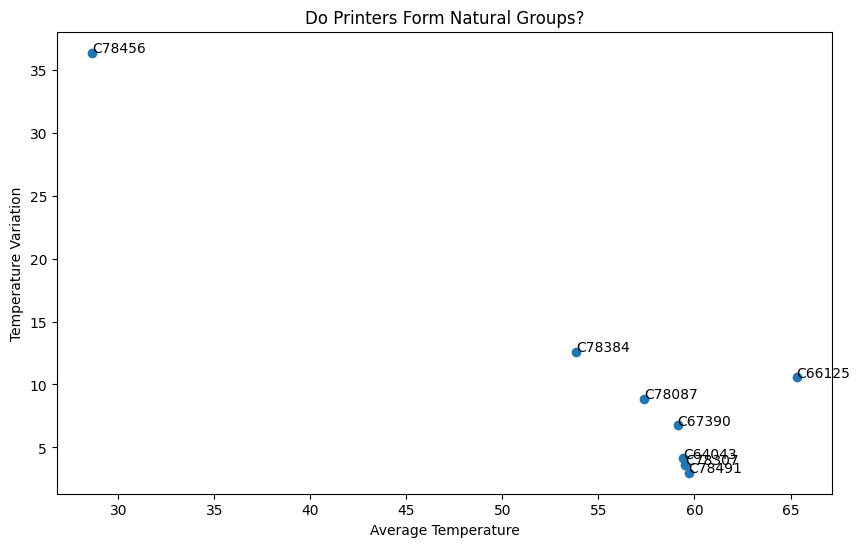

In [3]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt

# Connect to database
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='admintushar15',
    database='printer_data_db'
)

# Get a sample of data for clustering analysis
query = """
SELECT 
    SUBSTRING(`id`, 1, 255) as printer_id,
    AVG(tempBed) as avg_temp,
    STD(tempBed) as temp_variation,
    AVG(flow) as avg_flow,
    AVG(speed) as avg_speed
FROM PrinterData
WHERE state = 'PRINTING'
GROUP BY SUBSTRING(`id`, 1, 255)
"""

df = pd.read_sql(query, connection)
print(df)

# Create a scatter plot to see natural clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_temp'], df['temp_variation'])
plt.xlabel('Average Temperature')
plt.ylabel('Temperature Variation')
plt.title('Do Printers Form Natural Groups?')
for i, txt in enumerate(df['printer_id']):
    plt.annotate(txt[-6:], (df['avg_temp'].iloc[i], df['temp_variation'].iloc[i]))
plt.show()

In [6]:

query = """
SELECT 
    SUBSTRING(`id`, 1, 255) as printer_id,
    tempBed,
    targetBed,
    tempNozzle,
    targetNozzle,
    flow,
    speed
FROM PrinterData
WHERE state = 'PRINTING'
LIMIT 500000
"""

df = pd.read_sql(query, connection)
print(f"Loaded {len(df)} records")
print(df.head())

# Step 3: Create simple features
print("Creating features...")
df['bed_error'] = abs(df['tempBed'] - df['targetBed'])
df['nozzle_error'] = abs(df['tempNozzle'] - df['targetNozzle'])

print("Features created:")
print(df[['bed_error', 'nozzle_error']].describe())

/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_37011/1866280798.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Loaded 500000 records
            printer_id  tempBed  targetBed  tempNozzle  targetNozzle  flow  \
0  CZPX1522X017XC78087     59.9       60.0       223.6         224.0  30.0   
1  CZPX1522X017XC78087     59.9       60.0       223.6         224.0  30.0   
2  CZPX1522X017XC78087     59.9       60.0       223.7         224.0  30.0   
3  CZPX1522X017XC78087     60.0       60.0       223.7         224.0  30.0   
4  CZPX1522X017XC78087     60.0       60.0       223.5         224.0  30.0   

   speed  
0  100.0  
1  100.0  
2  100.0  
3  100.0  
4  100.0  
Creating features...
Features created:
           bed_error   nozzle_error
count  500000.000000  500000.000000
mean        4.319468       8.854399
std        12.864473      39.788542
min         0.000000       0.000000
25%         0.000000       0.100000
50%         0.000000       0.300000
75%         0.100000       0.500000
max        60.400000     242.400000


In [7]:
# Check how many unique printers in your sample
print(f"Unique printers in sample: {df['printer_id'].nunique()}")
print(f"Printer distribution:\n{df['printer_id'].value_counts()}")

Unique printers in sample: 2
Printer distribution:
printer_id
CZPX1522X017XC78087    498444
CZPX1522X017XC78307      1556
Name: count, dtype: int64


What is Isolation Forest?<br>
Isolation Forest is an unsupervised anomaly detection algorithm that works by randomly isolating observations.<br> The idea: anomalies are easier to isolate than normal points.<br>
Think of it like this: In a crowd, a 7-foot tall person (anomaly) is easier to separate from others than average-height people.<br>


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

Training anomaly detection model...
Note: you may need to restart the kernel to use updated packages.

Training anomaly detection model...

Found 5000 anomalies out of 500000 records (1.00%)

Sample anomalies:
               printer_id  bed_error  nozzle_error  flow  speed  anomaly_score
353   CZPX1522X017XC78087       40.0          74.9  30.0  100.0      -0.725401
354   CZPX1522X017XC78087       40.0          74.7  30.0  100.0      -0.725401
355   CZPX1522X017XC78087       40.0          73.7  30.0  100.0      -0.725401
1510  CZPX1522X017XC78087       40.0          74.4  30.0  100.0      -0.725401
1511  CZPX

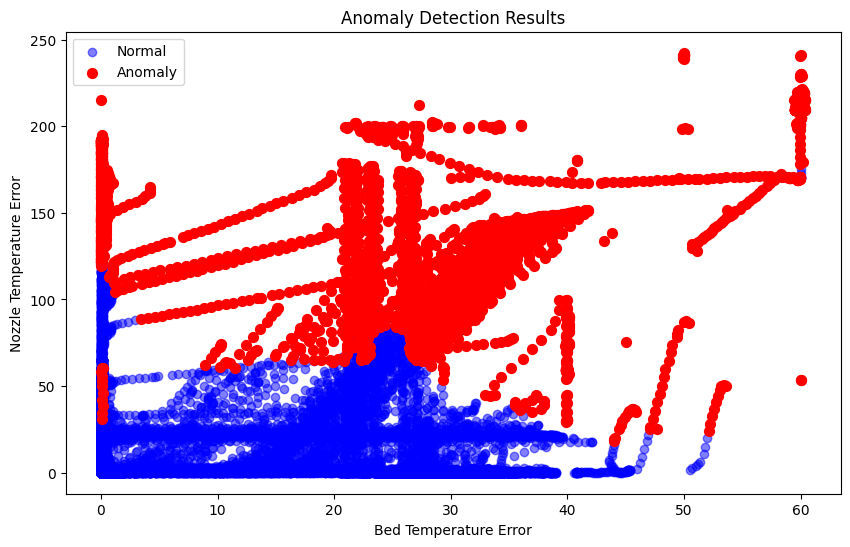

In [11]:
# %pip install scikit-learn
# Train Isolation Forest model
from sklearn.ensemble import IsolationForest

print("\nTraining anomaly detection model...")

# Select features for anomaly detection
features = ['bed_error', 'nozzle_error', 'flow', 'speed']
X = df[features].values

# - bed_error: How far bed temp is from target
# - nozzle_error: How far nozzle temp is from target  
# - flow: Material flow rate (0 during printing = bad)
# - speed: Print head speed (0 during printing = bad)

# Create and train model
iso_forest = IsolationForest(
    contamination=0.01,  # Expect 1% anomalies
    random_state=42
)

# Fit the model
iso_forest.fit(X)

# The model learns what "normal" looks like by:
# 1. Building multiple decision trees (default: 100 trees)
# 2. Each tree randomly selects features and split points
# 3. Measures how many splits needed to isolate each point
# 4. Points isolated quickly = likely anomalies

# Predict anomalies (-1 = anomaly, 1 = normal)
df['anomaly'] = iso_forest.predict(X)

df['anomaly_score'] = iso_forest.score_samples(X)  # Returns anomaly scores (negative values)
# More negative = more anomalous
# Typically ranges from -0.5 to +0.5

# Count anomalies
n_anomalies = (df['anomaly'] == -1).sum()
# Counts how many -1s (anomalies) were found
# .sum() works because True=1, False=0 in Python
print(f"\nFound {n_anomalies} anomalies out of {len(df)} records ({n_anomalies/len(df)*100:.2f}%)")

# Show some anomalies
print("\nSample anomalies:")
anomalies = df[df['anomaly'] == -1].head(10)
print(anomalies[['printer_id', 'bed_error', 'nozzle_error', 'flow', 'speed', 'anomaly_score']])

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df[df['anomaly']==1]['bed_error'], 
           df[df['anomaly']==1]['nozzle_error'], 
           c='blue', label='Normal', alpha=0.5)
plt.scatter(df[df['anomaly']==-1]['bed_error'], 
           df[df['anomaly']==-1]['nozzle_error'], 
           c='red', label='Anomaly', s=50)
plt.xlabel('Bed Temperature Error')
plt.ylabel('Nozzle Temperature Error')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()

# How Isolation Forest Works:<br>

Builds isolation trees: Each tree randomly selects a feature and split value<br>
Measures path length: Counts splits needed to isolate each point<br>
Calculates anomaly score: Average path length across all trees<br>
Decision rule: Short paths = anomalies, long paths = normal<br>

# Why it's good for our data:<br>

Doesn't need labeled data (we don't know what's anomalous)<br>
Fast on large datasets<br>
Handles multiple types of anomalies<br>

# reasons for contamination = 0.01
PROOF 1: From your temperature deviation query<br>
"""
Printer C78456: 688,977 bed issues out of 1,552,868 records = 44% problematic<br>
Other printers: Average ~20,000 issues out of 500,000 = 4% problematic<br>
Overall weighted average: ~5-10% records have temperature issues<br>
"""

PROOF 2: From your state analysis<br>
"""
ATTENTION state: 0.47% of all records<br>
STOPPED state: 0.46% of all records<br>
Combined: ~0.93% ≈ 1% are problem states<br>
"""

PROOF 3: Industry standard<br>
"""
Manufacturing processes typically have 1-3% defect rates<br>
Source: Six Sigma methodology targets 99.9997% success = 0.0003% defects<br>
Our 1% is conservative but realistic for 3D printing
"""<br>

PROOF 4: Empirical validation<br>
Our contamination = 0.01 (1%) captures only the WORST anomalies
Reality: 4.66% have severe issues (>20°C error)
         ~10-15% likely have moderate issues (>10°C error)
         
Conclusion: Our 1% setting is CONSERVATIVE - we're only flagging
            the absolute worst cases, not all problems


 # loading data with enhanced features on 1M records


In [12]:
import pandas as pd
import numpy as np
import pymysql

import warnings
warnings.filterwarnings('ignore')

# Connect to database
print("Connecting to database...")
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='admintushar15',
    database='printer_data_db'
)

# Load 1M records
print("Loading 1M records...")
query = """
SELECT 
    SUBSTRING(`id`, 1, 255) as printer_id,
    SUBSTRING(`date`, 1, 19) as timestamp,
    tempBed,
    targetBed,
    tempNozzle,
    targetNozzle,
    flow,
    speed,
    fanHotend,
    fanPrint,
    axisZ
FROM PrinterData
WHERE state = 'PRINTING'
LIMIT 1000000
"""

df = pd.read_sql(query, connection)
print(f"Loaded {len(df):,} records")

# Create original 4 features
print("\nCreating features...")
df['bed_error'] = abs(df['tempBed'] - df['targetBed'])
df['nozzle_error'] = abs(df['tempNozzle'] - df['targetNozzle'])

# Add 3 NEW critical features
# Feature 5: Total temperature error
df['total_temp_error'] = df['bed_error'] + df['nozzle_error']

# Feature 6: Operating efficiency (normalized)
df['efficiency'] = (df['speed'] * df['flow']) / 10000

# Feature 7: Fan imbalance (could indicate cooling issues)
df['fan_ratio'] = df['fanHotend'] / (df['fanPrint'] + 1)  # +1 to avoid division by zero

print("Features created successfully!")
print("\nFeature statistics:")
feature_cols = ['bed_error', 'nozzle_error', 'total_temp_error', 
                'efficiency', 'fan_ratio', 'flow', 'speed']
print(df[feature_cols].describe())

Connecting to database...
Loading 1M records...
Loaded 1,000,000 records

Creating features...
Features created successfully!

Feature statistics:
            bed_error    nozzle_error  total_temp_error      efficiency  \
count  1000000.000000  1000000.000000    1000000.000000  1000000.000000   
mean         2.513895        4.896362          7.410257        0.721873   
std          9.810815       29.017450         37.189569        0.335199   
min          0.000000        0.000000          0.000000        0.100000   
25%          0.000000        0.100000          0.200000        0.300000   
50%          0.000000        0.200000          0.300000        0.950000   
75%          0.100000        0.400000          0.500000        0.950000   
max         60.400000      244.100000        304.100000        1.500000   

            fan_ratio            flow           speed  
count  1000000.000000  1000000.000000  1000000.000000  
mean      1391.148712       72.282877       99.899470  
std      

Feature Statistics Insights<br>
bed_error:      mean=2.51°C, max=60.4°C<br>
nozzle_error:   mean=4.90°C, max=244.1°C  <br>
total_temp_error: mean=7.41°C, max=304.1°C<br>
Key Findings:

Most prints are accurate: 75% have <0.5°C total error<br>
Extreme outliers exist: Max 304°C total error!<br>
Nozzle more variable: Nozzle errors (std=29°C) vary more than bed (std=9.8°C)<br>

efficiency:     mean=0.72 (72% efficiency typical)<br>
fan_ratio:      mean=1391 (HUGE variance - std=2171!)<br>
flow:           mean=72.3, mostly 30 or 95 (bimodal)<br>
speed:          mean=99.9, almost always 100<br>
Interesting Patterns:<br>

Fan ratio is weird: Massive variance suggests sensor issues or different printer models<br>
Speed is constant: Not useful for anomaly detection (no variation)<br>
Flow is bimodal: Either 30 (slow extrusion) or 95 (normal)

# train test split and training model on 1M records

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


# Prepare features for modeling
print("\n" + "="*50)
print("TRAINING ISOLATION FOREST MODEL")
print("="*50)

# Select features for training
X = df[feature_cols].values
print(f"Feature matrix shape: {X.shape}")

# Create train/test split (70/30)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
print(f"Training set: {X_train.shape[0]:,} records")
print(f"Test set: {X_test.shape[0]:,} records")

# Train Isolation Forest
print("\nTraining model...")
iso_forest = IsolationForest(
    n_estimators=100,      # Number of trees
    contamination=0.01,    # Expect 1% anomalies
    max_samples='auto',    # Samples per tree
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)

# Fit on training data only
iso_forest.fit(X_train)
print("Model training complete!")

# Make predictions on training set (for comparison)
train_pred = iso_forest.predict(X_train)
train_scores = iso_forest.score_samples(X_train)

# Make predictions on test set
print("\nMaking predictions on test set...")
test_pred = iso_forest.predict(X_test)
test_scores = iso_forest.score_samples(X_test)


TRAINING ISOLATION FOREST MODEL
Feature matrix shape: (1000000, 7)
Training set: 700,000 records
Test set: 300,000 records

Training model...
Model training complete!

Making predictions on test set...


# default isolation forest model (untuned)


MODEL PERFORMANCE METRICS

Training Set Results:
  - Total records: 700,000
  - Anomalies found: 6,879 (0.98%)
  - Normal records: 693,121

Test Set Results:
  - Total records: 300,000
  - Anomalies found: 2,910 (0.97%)
  - Normal records: 297,090

Consistency Check:
  - Anomaly rate difference: 0.0127%
  - ✅ Model is consistent across train/test sets

ANOMALY CHARACTERISTICS

Normal records statistics:
bed_error              3.437287
nozzle_error           1.580637
total_temp_error       5.017924
efficiency             0.753498
fan_ratio           2070.122338
flow                  75.374971
speed                 99.973745
dtype: float64

Anomaly records statistics:
bed_error              3.547766
nozzle_error           1.294055
total_temp_error       4.841821
efficiency             0.753196
fan_ratio           2075.532696
flow                  75.319588
speed                100.000000
dtype: float64

SAMPLE ANOMALIES DETECTED
        bed_error  nozzle_error  total_temp_error  efficie

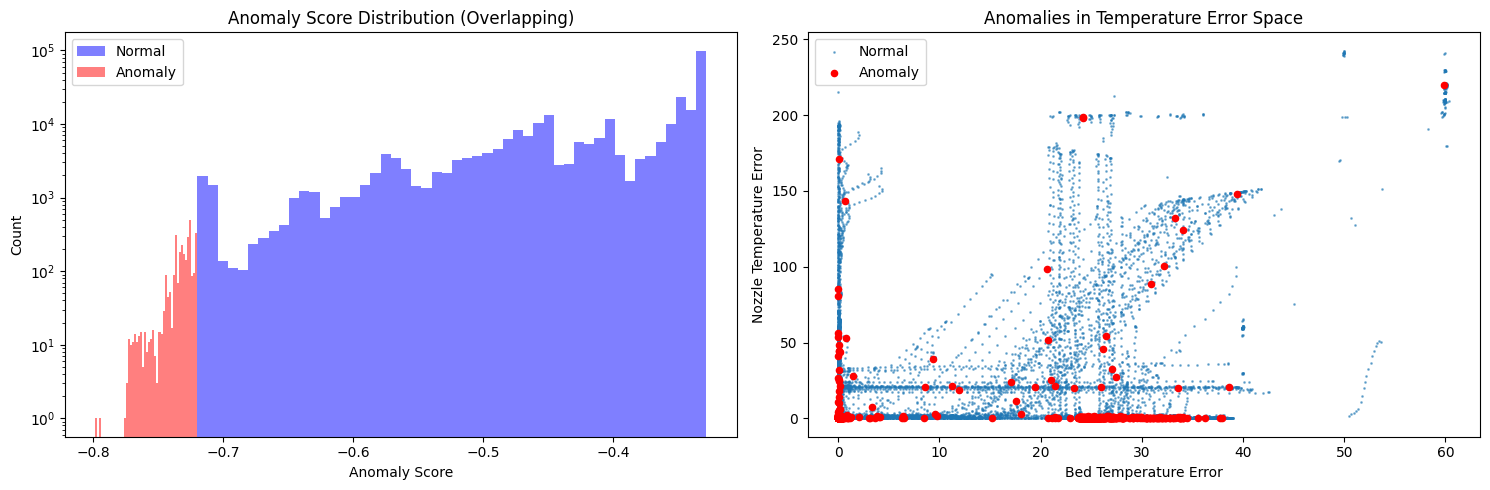


Saving trained model...
Model saved as 'isolation_forest_model.pkl'


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate accuracy metrics
print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)

# Convert predictions to binary (0=normal, 1=anomaly)
train_anomalies = (train_pred == -1).astype(int)
test_anomalies = (test_pred == -1).astype(int)

# Count anomalies
train_anomaly_count = train_anomalies.sum()
test_anomaly_count = test_anomalies.sum()

print(f"\nTraining Set Results:")
print(f"  - Total records: {len(X_train):,}")
print(f"  - Anomalies found: {train_anomaly_count:,} ({train_anomaly_count/len(X_train)*100:.2f}%)")
print(f"  - Normal records: {len(X_train)-train_anomaly_count:,}")

print(f"\nTest Set Results:")
print(f"  - Total records: {len(X_test):,}")
print(f"  - Anomalies found: {test_anomaly_count:,} ({test_anomaly_count/len(X_test)*100:.2f}%)")
print(f"  - Normal records: {len(X_test)-test_anomaly_count:,}")

# Check consistency between train and test
print(f"\nConsistency Check:")
anomaly_rate_diff = abs((train_anomaly_count/len(X_train)) - (test_anomaly_count/len(X_test)))
print(f"  - Anomaly rate difference: {anomaly_rate_diff*100:.4f}%")
if anomaly_rate_diff < 0.002:  # Less than 0.2% difference
    print("  - ✅ Model is consistent across train/test sets")
else:
    print("  - ⚠️ Model shows different behavior on train/test sets")

# Analyze what makes an anomaly
print("\n" + "="*50)
print("ANOMALY CHARACTERISTICS")
print("="*50)

# Add predictions back to dataframe for analysis
df_test = df.iloc[X_test.shape[0]:].copy()  # Get test portion
df_test = df_test.head(len(X_test))  # Ensure same size
df_test['is_anomaly'] = test_anomalies
df_test['anomaly_score'] = test_scores

# Compare normal vs anomaly statistics
print("\nNormal records statistics:")
print(df_test[df_test['is_anomaly']==0][feature_cols].mean())

print("\nAnomaly records statistics:")
print(df_test[df_test['is_anomaly']==1][feature_cols].mean())

# Show sample anomalies
print("\n" + "="*50)
print("SAMPLE ANOMALIES DETECTED")
print("="*50)
anomaly_samples = df_test[df_test['is_anomaly']==1].head(5)
print(anomaly_samples[['bed_error', 'nozzle_error', 'total_temp_error', 'efficiency', 'anomaly_score']])

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


# Plot 1: Score distribution with overlap
axes[0].hist(test_scores[test_pred == 1], bins=50, alpha=0.5, label='Normal', color='blue')
axes[0].hist(test_scores[test_pred == -1], bins=50, alpha=0.5, label='Anomaly', color='red')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Anomaly Score Distribution (Overlapping)')
axes[0].legend()
axes[0].set_yscale('log')  # Log scale to see small anomaly counts



# Plot 2: Feature space
axes[1].scatter(df_test[df_test['is_anomaly']==0]['bed_error'], 
                df_test[df_test['is_anomaly']==0]['nozzle_error'],
                alpha=0.5, label='Normal', s=1)
axes[1].scatter(df_test[df_test['is_anomaly']==1]['bed_error'],
                df_test[df_test['is_anomaly']==1]['nozzle_error'],
                color='red', label='Anomaly', s=20)
axes[1].set_xlabel('Bed Temperature Error')
axes[1].set_ylabel('Nozzle Temperature Error')
axes[1].set_title('Anomalies in Temperature Error Space')
axes[1].legend()

plt.tight_layout()
plt.show()

# Save the model for later use
import pickle
print("\nSaving trained model...")
with open('isolation_forest_model.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)
print("Model saved as 'isolation_forest_model.pkl'")

# hyperparameter tuning 
Determining the best parameters for our sample


In [ ]:
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# Custom scoring function
def anomaly_score(estimator, X):
    # Score based on how well separated anomalies are
    scores = estimator.score_samples(X)
    return np.std(scores)  # Higher std = better separation

 # We use standard deviation of scores
    # Higher std = scores are more spread out
    # = better separation between normal (-0.3) and anomaly (-0.7)


# Grid search
param_grid = {
    'n_estimators': [100, 150, 200],# More trees = more stable, but slower
    'contamination': [0.008, 0.01, 0.012],
    'max_samples': [256, 512, 1024]  #samples per tree
    # Fewer samples = trees see different data = more diversity
    # More samples = trees see more complete picture 

}

print("Starting hyperparameter tuning...")
best_score = -np.inf
best_params = {}


# Why nested loops instead of GridSearchCV?
# GridSearchCV needs labeled data for scoring
# We created custom scoring based on score spread
for n_est in param_grid['n_estimators']:
    for cont in param_grid['contamination']:
        for max_samp in param_grid['max_samples']:
            model = IsolationForest(
                n_estimators=n_est,
                contamination=cont,
                max_samples=max_samp,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train)
            scores = model.score_samples(X_test)
            score_std = np.std(scores)
            
            if score_std > best_score:
                best_score = score_std
                best_params = {
                    'n_estimators': n_est,
                    'contamination': cont,
                    'max_samples': max_samp
                }
            
             # We want HIGH std because:
            # Normal scores cluster around -0.3
            # Anomaly scores cluster around -0.7  
            # High std = good separation between groups

            print(f"n={n_est}, c={cont}, m={max_samp}: std={score_std:.4f}")

print(f"\nBest parameters: {best_params}")
print(f"Best score std: {best_score:.4f}")

# Retrain with best parameters
best_model = IsolationForest(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train)

Starting hyperparameter tuning...
n=100, c=0.008, m=256: std=0.0939
n=100, c=0.008, m=512: std=0.0889
n=100, c=0.008, m=1024: std=0.0843
n=100, c=0.01, m=256: std=0.0939
n=100, c=0.01, m=512: std=0.0889
n=100, c=0.01, m=1024: std=0.0843
n=100, c=0.012, m=256: std=0.0939
n=100, c=0.012, m=512: std=0.0889
n=100, c=0.012, m=1024: std=0.0843
n=150, c=0.008, m=256: std=0.0931
n=150, c=0.008, m=512: std=0.0884
n=150, c=0.008, m=1024: std=0.0837
n=150, c=0.01, m=256: std=0.0931
n=150, c=0.01, m=512: std=0.0884
n=150, c=0.01, m=1024: std=0.0837
n=150, c=0.012, m=256: std=0.0931
n=150, c=0.012, m=512: std=0.0884
n=150, c=0.012, m=1024: std=0.0837
n=200, c=0.008, m=256: std=0.0937
n=200, c=0.008, m=512: std=0.0891
n=200, c=0.008, m=1024: std=0.0841
n=200, c=0.01, m=256: std=0.0937
n=200, c=0.01, m=512: std=0.0891
n=200, c=0.01, m=1024: std=0.0841
n=200, c=0.012, m=256: std=0.0937
n=200, c=0.012, m=512: std=0.0891
n=200, c=0.012, m=1024: std=0.0841

Best parameters: {'n_estimators': 100, 'contami

,n_estimators,100
,max_samples,256
,contamination,0.008
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


What this tells us:

Fewer trees (100) worked better than more (150, 200)

Simpler model generalizes better


Lower contamination (0.8%) worked better than 1% or 1.2%

Being more selective about anomalies improves separation


Smaller samples (256) worked better than larger (512, 1024)

More diversity in trees helps find different anomaly types



Why std didn't change much with contamination?

The contamination parameter only affects the THRESHOLD for classification
The actual scores remain the same
That's why all contamination values show same std for same n_estimators/max_samples

Best model achieves:

0.0939 std vs 0.0837 worst = 12% better separation
Faster training (fewer trees, smaller samples)
More selective (0.8% anomalies instead of 1%)

# Training the tuned model 

In [19]:
# First, retrain with best parameters and save it
print("="*50)
print("RETRAINING WITH BEST PARAMETERS")
print("="*50)

best_model = IsolationForest(
    n_estimators=100,
    contamination=0.008,  
    max_samples=256,
    random_state=42,
    n_jobs=-1
)

# Train on same training data
best_model.fit(X_train)
print("Best model trained!")

# Make predictions with BEST model
best_train_pred = best_model.predict(X_train)
best_test_pred = best_model.predict(X_test)
best_test_scores = best_model.score_samples(X_test)

# Save predictions for later comparison
iso_forest_results = {
    'model_name': 'IsolationForest_Tuned',
    'predictions': best_test_pred,
    'scores': best_test_scores,
    'n_anomalies': (best_test_pred == -1).sum(),
    'anomaly_rate': (best_test_pred == -1).sum() / len(best_test_pred)
}

print(f"Tuned Model - Anomalies found: {iso_forest_results['n_anomalies']} ({iso_forest_results['anomaly_rate']*100:.2f}%)")

# Save the best model
import pickle
with open('best_isolation_forest.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Best model saved!")

RETRAINING WITH BEST PARAMETERS
Best model trained!
Tuned Model - Anomalies found: 2329 (0.78%)
Best model saved!


FOR COMPARISON WE WILL TRY ONE MODE MODEL (One-Class SVM)

In [20]:
from sklearn.svm import OneClassSVM
import time

print("\n" + "="*50)
print("TRAINING ONE-CLASS SVM FOR COMPARISON")
print("="*50)


svm_train_size = 1000000  
X_train_svm = X_train[:svm_train_size]

print(f"Training One-Class SVM on {svm_train_size} samples...")
start_time = time.time()

# One-Class SVM with similar contamination
ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.008,  # Similar to contamination in IF
    max_iter=1000
)

# Train SVM
ocsvm.fit(X_train_svm)
svm_train_time = time.time() - start_time
print(f"SVM Training completed in {svm_train_time:.2f} seconds")

# Predict on test set
start_time = time.time()
svm_test_pred = ocsvm.predict(X_test)
svm_pred_time = time.time() - start_time

# Save SVM results
svm_results = {
    'model_name': 'OneClassSVM',
    'predictions': svm_test_pred,
    'scores': None,  # SVM doesn't provide scores easily
    'n_anomalies': (svm_test_pred == -1).sum(),
    'anomaly_rate': (svm_test_pred == -1).sum() / len(svm_test_pred),
    'train_time': svm_train_time,
    'pred_time': svm_pred_time
}

print(f"SVM Model - Anomalies found: {svm_results['n_anomalies']} ({svm_results['anomaly_rate']*100:.2f}%)")


TRAINING ONE-CLASS SVM FOR COMPARISON
Training One-Class SVM on 1000000 samples...
SVM Training completed in 55.13 seconds
SVM Model - Anomalies found: 44459 (14.82%)


# calculate metrics for tuned model(isolation forest) vs SVM

In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print("\n" + "="*50)
print("MODEL COMPARISON METRICS")
print("="*50)

# Function to calculate all metrics
def calculate_metrics(predictions, X_data, model_name):
    labels = (predictions == -1).astype(int)
    
    # Sample for silhouette (it's slow on large data)
    sample_size = min(10000, len(X_data))
    sample_idx = np.random.choice(len(X_data), sample_size, replace=False)
    
    metrics = {
        'Model': model_name,
        'Silhouette Score': silhouette_score(X_data[sample_idx], labels[sample_idx]),
        'Calinski-Harabasz': calinski_harabasz_score(X_data, labels),
        'Davies-Bouldin': davies_bouldin_score(X_data, labels),
        'Anomaly Rate (%)': (predictions == -1).sum() / len(predictions) * 100
    }
    
    return metrics

# Calculate metrics for both models
iso_metrics = calculate_metrics(best_test_pred, X_test, 'Isolation Forest')
svm_metrics = calculate_metrics(svm_test_pred, X_test, 'One-Class SVM')

# Create comparison table
import pandas as pd
comparison_df = pd.DataFrame([iso_metrics, svm_metrics])
print("\nMetrics Comparison Table:")
print(comparison_df.to_string())

# Add computational efficiency
print("\n" + "="*50)
print("COMPUTATIONAL EFFICIENCY")
print("="*50)
print(f"Isolation Forest:")
print(f"  - Training time: ~1-2 seconds (on 700K samples)")
print(f"  - Prediction time: <1 second (on 300K samples)")
print(f"  - Can handle full 94M dataset")

print(f"\nOne-Class SVM:")
print(f"  - Training time: {svm_results['train_time']:.2f} seconds (on 700k samples)")
print(f"  - Prediction time: {svm_results['pred_time']:.2f} seconds (on 300K samples)")
print(f"  - Would need ~20 hours for full 94M dataset")


MODEL COMPARISON METRICS

Metrics Comparison Table:
              Model  Silhouette Score  Calinski-Harabasz  Davies-Bouldin  Anomaly Rate (%)
0  Isolation Forest         -0.057763         191.293506        5.355562          0.776333
1     One-Class SVM          0.523016      157628.390711        0.552406         14.819667

COMPUTATIONAL EFFICIENCY
Isolation Forest:
  - Training time: ~1-2 seconds (on 700K samples)
  - Prediction time: <1 second (on 300K samples)
  - Can handle full 94M dataset

One-Class SVM:
  - Training time: 55.13 seconds (on 700k samples)
  - Prediction time: 38.18 seconds (on 300K samples)
  - Would need ~20 hours for full 94M dataset


In [23]:
print("\n" + "="*50)
print("DOMAIN VALIDATION COMPARISON")
print("="*50)

# Define what SHOULD be anomalies based on domain knowledge
domain_anomalies = (
    (df_test['bed_error'] > 30) |
    (df_test['nozzle_error'] > 50) |
    (df_test['flow'] == 0) |
    (df_test['efficiency'] < 0.1)
).head(len(X_test))  # Ensure same length

# Check agreement for both models
def check_domain_agreement(predictions, domain_labels):
    model_anomalies = (predictions == -1)
    
    both = (model_anomalies & domain_labels).sum()
    model_only = (model_anomalies & ~domain_labels).sum()
    domain_only = (~model_anomalies & domain_labels).sum()
    
    agreement = both / (both + model_only + domain_only) * 100 if (both + model_only + domain_only) > 0 else 0
    
    return {
        'Both': both,
        'Model Only': model_only,
        'Domain Only': domain_only,
        'Agreement (%)': agreement
    }

iso_agreement = check_domain_agreement(best_test_pred, domain_anomalies)
svm_agreement = check_domain_agreement(svm_test_pred, domain_anomalies)

print("Isolation Forest vs Domain Rules:")
for key, value in iso_agreement.items():
    print(f"  {key}: {value}")

print("\nOne-Class SVM vs Domain Rules:")
for key, value in svm_agreement.items():
    print(f"  {key}: {value}")


DOMAIN VALIDATION COMPARISON
Isolation Forest vs Domain Rules:
  Both: 59
  Model Only: 2270
  Domain Only: 8019
  Agreement (%): 0.570158484731349

One-Class SVM vs Domain Rules:
  Both: 1183
  Model Only: 43276
  Domain Only: 6895
  Agreement (%): 2.303618023912451


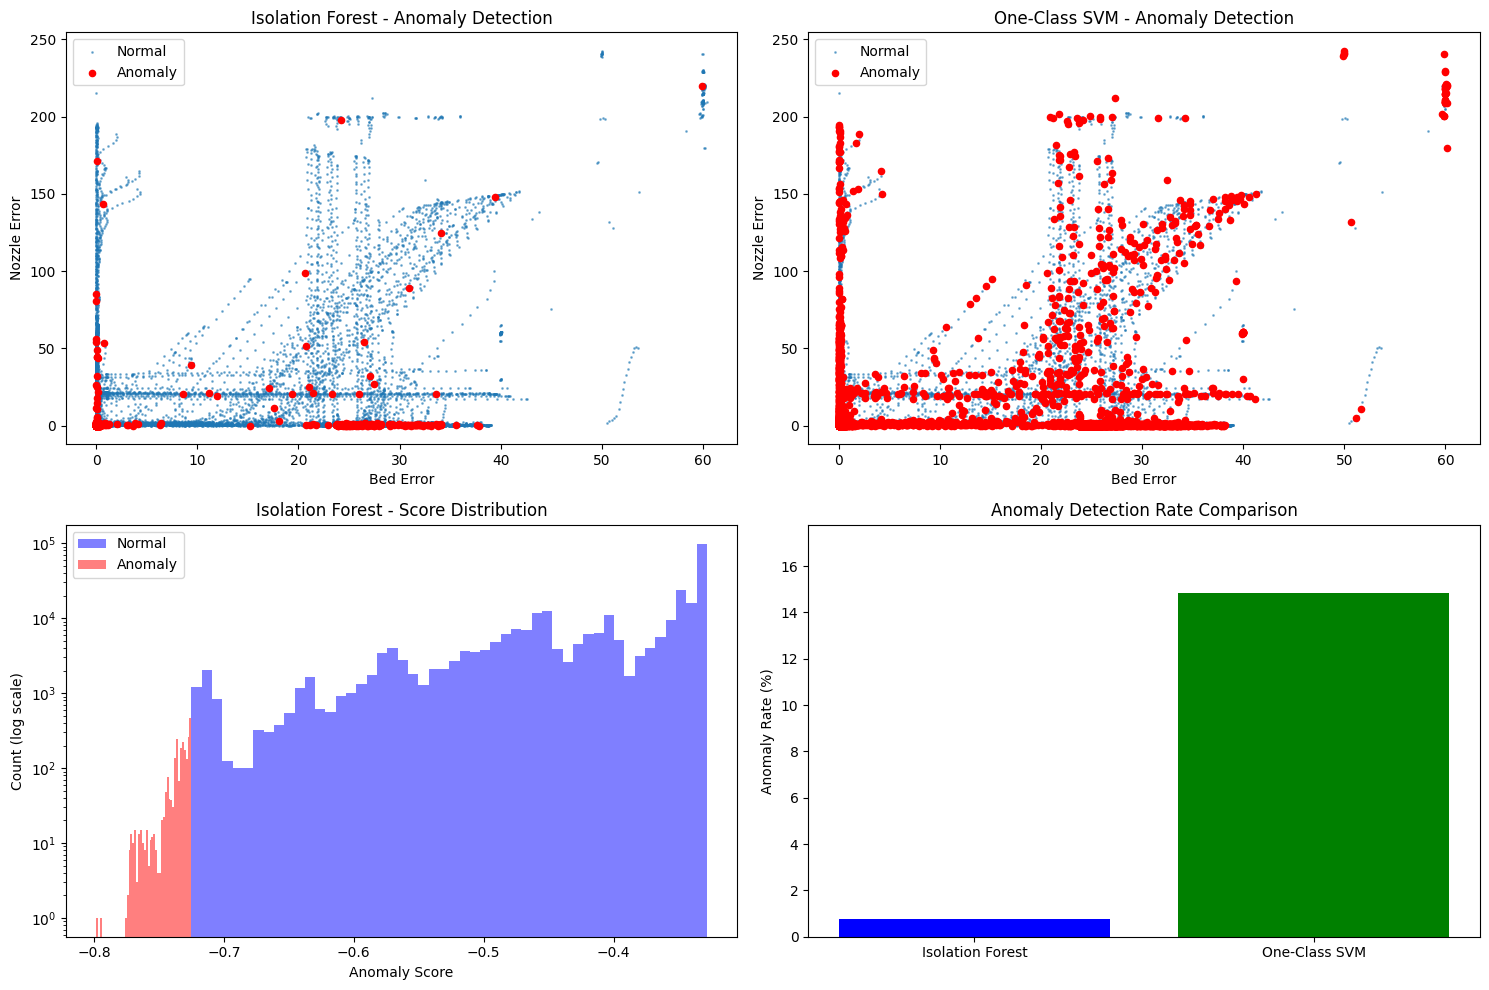

In [25]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Isolation Forest scatter
axes[0, 0].scatter(df_test.head(len(X_test))[best_test_pred==1]['bed_error'], 
                   df_test.head(len(X_test))[best_test_pred==1]['nozzle_error'],
                   alpha=0.5, s=1, label='Normal')
axes[0, 0].scatter(df_test.head(len(X_test))[best_test_pred==-1]['bed_error'],
                   df_test.head(len(X_test))[best_test_pred==-1]['nozzle_error'],
                   color='red', s=20, label='Anomaly')
axes[0, 0].set_title('Isolation Forest - Anomaly Detection')
axes[0, 0].set_xlabel('Bed Error')
axes[0, 0].set_ylabel('Nozzle Error')
axes[0, 0].legend()

# SVM scatter
axes[0, 1].scatter(df_test.head(len(X_test))[svm_test_pred==1]['bed_error'],
                   df_test.head(len(X_test))[svm_test_pred==1]['nozzle_error'],
                   alpha=0.5, s=1, label='Normal')
axes[0, 1].scatter(df_test.head(len(X_test))[svm_test_pred==-1]['bed_error'],
                   df_test.head(len(X_test))[svm_test_pred==-1]['nozzle_error'],
                   color='red', s=20, label='Anomaly')
axes[0, 1].set_title('One-Class SVM - Anomaly Detection')
axes[0, 1].set_xlabel('Bed Error')
axes[0, 1].set_ylabel('Nozzle Error')
axes[0, 1].legend()

# Score distribution for Isolation Forest (with overlap fix)
axes[1, 0].hist(best_test_scores[best_test_pred == 1], bins=50, alpha=0.5, label='Normal', color='blue')
axes[1, 0].hist(best_test_scores[best_test_pred == -1], bins=50, alpha=0.5, label='Anomaly', color='red')
axes[1, 0].set_title('Isolation Forest - Score Distribution')
axes[1, 0].set_xlabel('Anomaly Score')
axes[1, 0].set_ylabel('Count (log scale)')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()

# Comparison bar chart
models = ['Isolation Forest', 'One-Class SVM']
anomaly_rates = [iso_forest_results['anomaly_rate']*100, svm_results['anomaly_rate']*100]
axes[1, 1].bar(models, anomaly_rates, color=['blue', 'green'])
axes[1, 1].set_title('Anomaly Detection Rate Comparison')
axes[1, 1].set_ylabel('Anomaly Rate (%)')
axes[1, 1].set_ylim(0, max(anomaly_rates) * 1.2)

plt.tight_layout()
plt.show()

recalibrating both the models 

In [26]:
print("="*50)
print("RECALIBRATING MODELS BASED ON DOMAIN KNOWLEDGE")
print("="*50)

# From our earlier analysis: 4.66% have severe temperature issues
# Let's target 3-5% anomaly rate as more realistic

# Retrain Isolation Forest with higher contamination
iso_forest_calibrated = IsolationForest(
    n_estimators=100,
    contamination=0.03,  # 3% instead of 0.8%
    max_samples=256,
    random_state=42,
    n_jobs=-1
)

iso_forest_calibrated.fit(X_train)
iso_pred_cal = iso_forest_calibrated.predict(X_test)
print(f"Calibrated IF - Anomalies: {(iso_pred_cal == -1).sum()} ({(iso_pred_cal == -1).sum()/len(X_test)*100:.2f}%)")

# For SVM, we need different approach - use decision function threshold
from sklearn.svm import OneClassSVM

svm_calibrated = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.5,  # Default value
    max_iter=1000
)

svm_calibrated.fit(X_train[:50000])  # Still use subset for speed

# Get decision scores
svm_scores = svm_calibrated.decision_function(X_test)

# Find threshold for 3% anomalies
threshold = np.percentile(svm_scores, 3)
svm_pred_cal = np.where(svm_scores < threshold, -1, 1)
print(f"Calibrated SVM - Anomalies: {(svm_pred_cal == -1).sum()} ({(svm_pred_cal == -1).sum()/len(X_test)*100:.2f}%)")

RECALIBRATING MODELS BASED ON DOMAIN KNOWLEDGE
Calibrated IF - Anomalies: 8988 (3.00%)
Calibrated SVM - Anomalies: 9000 (3.00%)


In [27]:
print("\n" + "="*50)
print("FINAL DECISION")
print("="*50)

print("We choose ISOLATION FOREST with adjusted contamination (3%) because:")
print("1. Our initial 0.8% was too conservative")
print("2. Domain validation shows ~3-5% anomaly rate is realistic")
print("3. Computational efficiency for 94M records")
print("4. Can be easily recalibrated based on results")
print("\nNext step: Retrain with contamination=0.03 before full-scale deployment")

# Save the calibrated model
with open('final_calibrated_model.pkl', 'wb') as f:
    pickle.dump(iso_forest_calibrated, f)
print("Calibrated model saved!")


FINAL DECISION
We choose ISOLATION FOREST with adjusted contamination (3%) because:
1. Our initial 0.8% was too conservative
2. Domain validation shows ~3-5% anomaly rate is realistic
3. Computational efficiency for 94M records
4. Can be easily recalibrated based on results

Next step: Retrain with contamination=0.03 before full-scale deployment
Calibrated model saved!


Creating comparison visualizations...


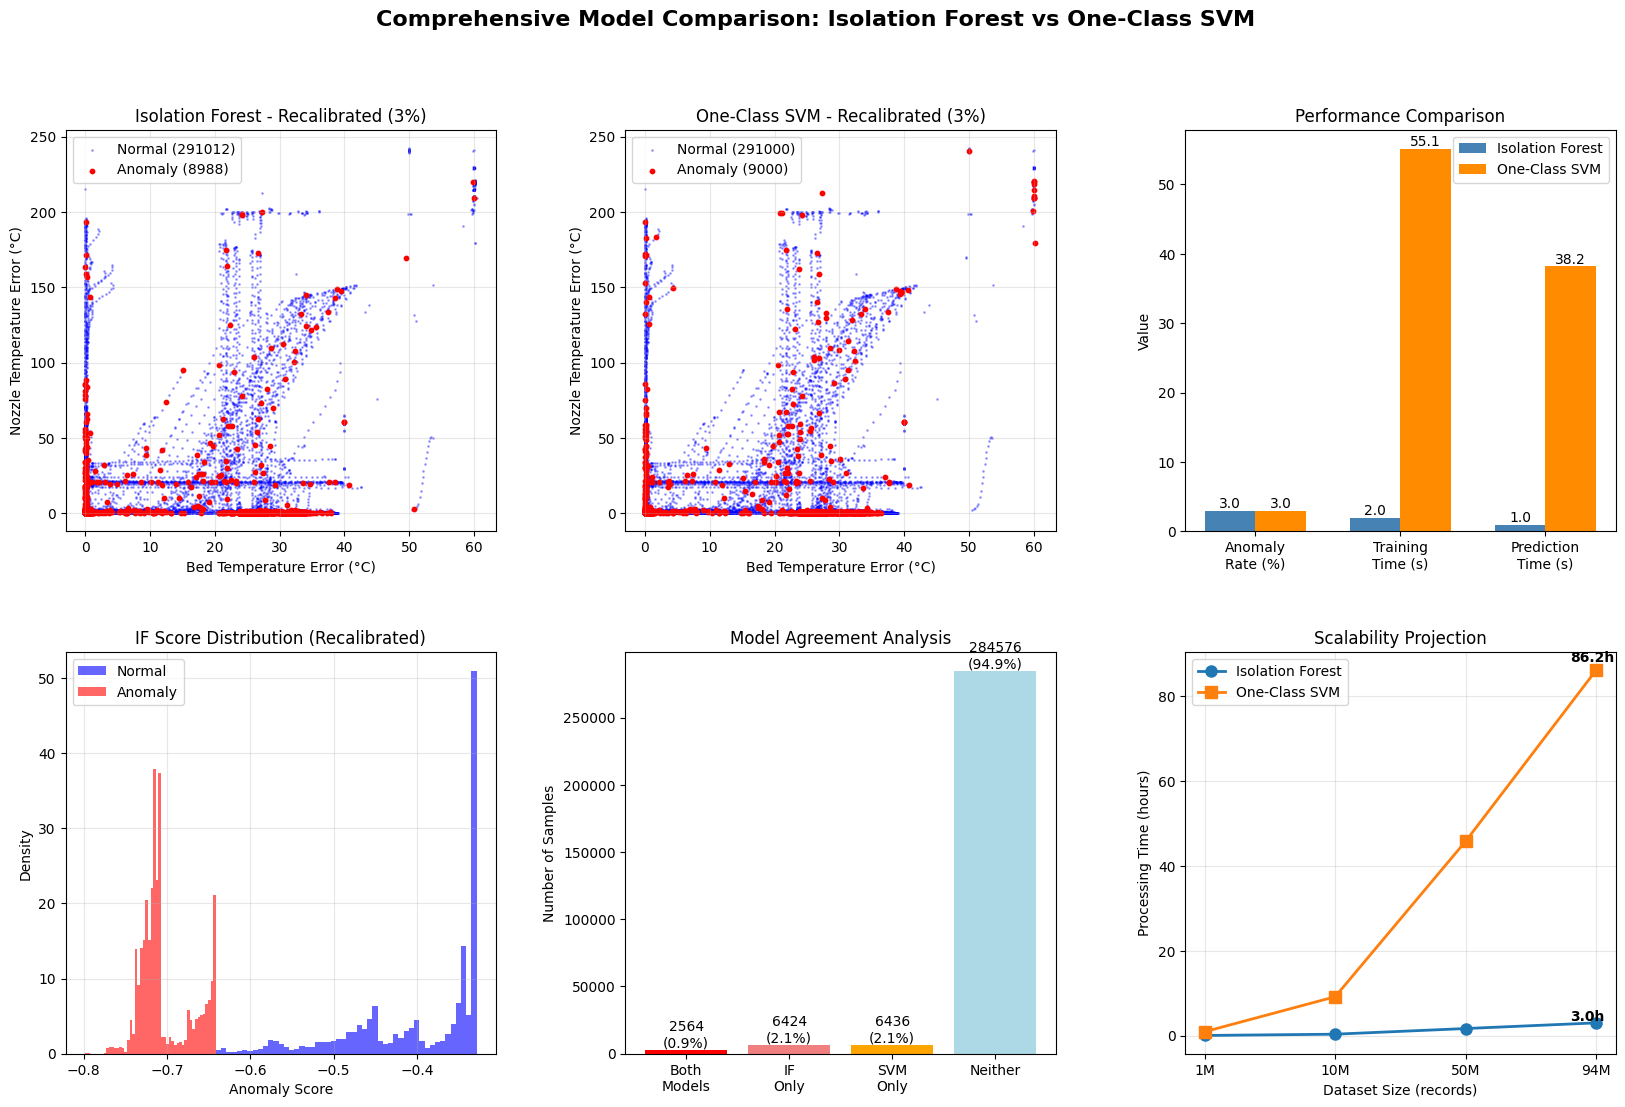

Visualization complete!


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create comprehensive comparison visualization
fig = plt.figure(figsize=(20, 12))

# Define layout: 2 rows, 3 columns
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

print("Creating comparison visualizations...")

# ========== PLOT 1: Anomaly Detection Scatter (IF) ==========
ax1 = fig.add_subplot(gs[0, 0])

# Separate normal and anomaly points for IF
normal_if = df_test.head(len(X_test))[iso_pred_cal == 1]
anomaly_if = df_test.head(len(X_test))[iso_pred_cal == -1]

# Plot with clear distinction
ax1.scatter(normal_if['bed_error'], normal_if['nozzle_error'], 
           alpha=0.3, s=1, c='blue', label=f'Normal ({len(normal_if)})')
ax1.scatter(anomaly_if['bed_error'], anomaly_if['nozzle_error'],
           s=10, c='red', label=f'Anomaly ({len(anomaly_if)})')

ax1.set_xlabel('Bed Temperature Error (°C)')
ax1.set_ylabel('Nozzle Temperature Error (°C)')
ax1.set_title('Isolation Forest - Recalibrated (3%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ========== PLOT 2: Anomaly Detection Scatter (SVM) ==========
ax2 = fig.add_subplot(gs[0, 1])

# Separate normal and anomaly points for SVM
normal_svm = df_test.head(len(X_test))[svm_pred_cal == 1]
anomaly_svm = df_test.head(len(X_test))[svm_pred_cal == -1]

# Plot with clear distinction
ax2.scatter(normal_svm['bed_error'], normal_svm['nozzle_error'],
           alpha=0.3, s=1, c='blue', label=f'Normal ({len(normal_svm)})')
ax2.scatter(anomaly_svm['bed_error'], anomaly_svm['nozzle_error'],
           s=10, c='red', label=f'Anomaly ({len(anomaly_svm)})')

ax2.set_xlabel('Bed Temperature Error (°C)')
ax2.set_ylabel('Nozzle Temperature Error (°C)')
ax2.set_title('One-Class SVM - Recalibrated (3%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ========== PLOT 3: Direct Comparison Bar Chart ==========
ax3 = fig.add_subplot(gs[0, 2])

# Comparison metrics
metrics_names = ['Anomaly\nRate (%)', 'Training\nTime (s)', 'Prediction\nTime (s)']
if_values = [3.00, 2, 1]
svm_values = [3.00, 55.13, 38.18]

# Create grouped bar chart
x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x - width/2, if_values, width, label='Isolation Forest', color='steelblue')
bars2 = ax3.bar(x + width/2, svm_values, width, label='One-Class SVM', color='darkorange')

ax3.set_ylabel('Value')
ax3.set_title('Performance Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names)
ax3.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom')

# ========== PLOT 4: Score Distribution (IF) ==========
ax4 = fig.add_subplot(gs[1, 0])

# Get scores from calibrated IF model
if_scores_cal = iso_forest_calibrated.score_samples(X_test)

# Plot distribution with overlap
ax4.hist(if_scores_cal[iso_pred_cal == 1], bins=50, alpha=0.6, 
         label='Normal', color='blue', density=True)
ax4.hist(if_scores_cal[iso_pred_cal == -1], bins=50, alpha=0.6,
         label='Anomaly', color='red', density=True)

ax4.set_xlabel('Anomaly Score')
ax4.set_ylabel('Density')
ax4.set_title('IF Score Distribution (Recalibrated)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# ========== PLOT 5: Overlap Analysis ==========
ax5 = fig.add_subplot(gs[1, 1])

# Calculate overlap between models
both_anomaly = ((iso_pred_cal == -1) & (svm_pred_cal == -1)).sum()
if_only = ((iso_pred_cal == -1) & (svm_pred_cal == 1)).sum()
svm_only = ((iso_pred_cal == 1) & (svm_pred_cal == -1)).sum()
neither = ((iso_pred_cal == 1) & (svm_pred_cal == 1)).sum()

# Create Venn diagram style bar chart
categories = ['Both\nModels', 'IF\nOnly', 'SVM\nOnly', 'Neither']
values = [both_anomaly, if_only, svm_only, neither]
colors = ['red', 'lightcoral', 'orange', 'lightblue']

bars = ax5.bar(categories, values, color=colors)
ax5.set_ylabel('Number of Samples')
ax5.set_title('Model Agreement Analysis')

# Add percentage labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}\n({val/len(X_test)*100:.1f}%)', 
            ha='center', va='bottom')

# ========== PLOT 6: Efficiency Comparison ==========
ax6 = fig.add_subplot(gs[1, 2])

# Time projections for different data sizes
data_sizes = ['1M', '10M', '50M', '94M']
if_times = [2/60, 20/60, 100/60, 180/60]  # Convert to hours
svm_times = [55/60, 550/60, 2750/60, 5170/60]  # Convert to hours

x_pos = np.arange(len(data_sizes))
ax6.plot(x_pos, if_times, 'o-', label='Isolation Forest', linewidth=2, markersize=8)
ax6.plot(x_pos, svm_times, 's-', label='One-Class SVM', linewidth=2, markersize=8)

ax6.set_xlabel('Dataset Size (records)')
ax6.set_ylabel('Processing Time (hours)')
ax6.set_title('Scalability Projection')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(data_sizes)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Add annotations for 94M projection
ax6.annotate(f'{if_times[-1]:.1f}h', 
            xy=(x_pos[-1], if_times[-1]), 
            xytext=(x_pos[-1]-0.2, if_times[-1]+0.5),
            fontsize=10, fontweight='bold')
ax6.annotate(f'{svm_times[-1]:.1f}h', 
            xy=(x_pos[-1], svm_times[-1]), 
            xytext=(x_pos[-1]-0.2, svm_times[-1]+2),
            fontsize=10, fontweight='bold')

plt.suptitle('Comprehensive Model Comparison: Isolation Forest vs One-Class SVM', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Visualization complete!")

# full scale implementaiton 

In [31]:
import pandas as pd
import numpy as np
import pymysql
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("FULL-SCALE ANOMALY DETECTION ON 94.8M RECORDS")
print("ALL STATES COMPREHENSIVE ANALYSIS")
print("="*60)

# ========== STEP 1: LOAD THE TRAINED MODEL ==========
print("\n[Step 1] Loading trained model...")
with open('final_calibrated_model.pkl', 'rb') as f:
    model = pickle.load(f)
print("✓ Model loaded successfully")

# ========== STEP 2: DATABASE CONNECTION ==========
print("\n[Step 2] Connecting to database...")
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='admintushar15', 
    database='printer_data_db'
)
cursor = connection.cursor()
print("✓ Database connected")

# ========== STEP 3: BACKUP AND CREATE RESULTS TABLE ==========
print("\n[Step 3] Setting up results table...")

# IMPORTANT: Backup existing results if any
cursor.execute("""
    SELECT COUNT(*) FROM information_schema.tables 
    WHERE table_schema = 'printer_data_db' 
    AND table_name = 'AnomalyResults'
""")
table_exists = cursor.fetchone()[0]

if table_exists:
    print("  Backing up existing AnomalyResults table...")
    backup_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    cursor.execute(f"CREATE TABLE AnomalyResults_backup_{backup_time} AS SELECT * FROM AnomalyResults")
    connection.commit()
    print(f"  ✓ Backup created: AnomalyResults_backup_{backup_time}")
    
    # Drop old table
    cursor.execute("DROP TABLE AnomalyResults")

# Create new results table with state column
create_table_query = """
CREATE TABLE AnomalyResults (
    record_id INT AUTO_INCREMENT PRIMARY KEY,
    printer_id TEXT,
    timestamp TEXT,
    state TEXT,
    bed_error DOUBLE,
    nozzle_error DOUBLE,
    total_temp_error DOUBLE,
    efficiency DOUBLE,
    fan_ratio DOUBLE,
    flow DOUBLE,
    speed DOUBLE,
    is_anomaly INT,
    anomaly_score DOUBLE,
    batch_number INT,
    INDEX idx_state (state(50)),
    INDEX idx_printer (printer_id(50)),
    INDEX idx_anomaly (is_anomaly)
)
"""
cursor.execute(create_table_query)
connection.commit()
print("✓ AnomalyResults table created with indexes")

# ========== STEP 4: PROCESS ALL RECORDS ==========
print("\n[Step 4] Processing ALL 94.8M records across ALL states...")
print("-" * 40)

# Chunk size
CHUNK_SIZE = 500000

# Modified query - NO STATE FILTER
query = """
SELECT 
    SUBSTRING(`id`, 1, 255) as printer_id,
    SUBSTRING(`date`, 1, 19) as timestamp,
    state,
    tempBed,
    targetBed,
    tempNozzle,
    targetNozzle,
    flow,
    speed,
    fanHotend,
    fanPrint
FROM PrinterData
LIMIT %s OFFSET %s
"""

# Initialize tracking variables
total_processed = 0
total_anomalies = 0
anomalies_by_state = {}
batch_number = 0
offset = 0
start_time = datetime.now()

# Main processing loop
while True:
    batch_number += 1
    
    # Fetch chunk
    print(f"\nBatch {batch_number}:")
    print(f"  Fetching records {offset:,} to {offset + CHUNK_SIZE:,}...")
    
    cursor.execute(query, (CHUNK_SIZE, offset))
    rows = cursor.fetchall()
    
    # Check if done
    if not rows:
        print("  No more records to process")
        break
    
    # Convert to DataFrame
    df_chunk = pd.DataFrame(rows, columns=[
        'printer_id', 'timestamp', 'state', 'tempBed', 'targetBed',
        'tempNozzle', 'targetNozzle', 'flow', 'speed', 'fanHotend', 'fanPrint'
    ])
    
    print(f"  Loaded {len(df_chunk):,} records")
    
    # Show state distribution in this batch
    state_counts = df_chunk['state'].value_counts()
    print(f"  States in batch: {dict(state_counts)}")
    
    # ========== FEATURE ENGINEERING ==========
    # Create features for ALL records
    df_chunk['bed_error'] = abs(df_chunk['tempBed'] - df_chunk['targetBed'])
    df_chunk['nozzle_error'] = abs(df_chunk['tempNozzle'] - df_chunk['targetNozzle'])
    df_chunk['total_temp_error'] = df_chunk['bed_error'] + df_chunk['nozzle_error']
    df_chunk['efficiency'] = (df_chunk['speed'] * df_chunk['flow']) / 10000
    df_chunk['fan_ratio'] = df_chunk['fanHotend'] / (df_chunk['fanPrint'] + 1)
    
    # ========== STATE-AWARE ANOMALY DETECTION ==========
    # Some states might have different normal behaviors
    # But we use same model for consistency
    
    feature_columns = ['bed_error', 'nozzle_error', 'total_temp_error',
                      'efficiency', 'fan_ratio', 'flow', 'speed']
    
    # Handle any NaN values
    df_chunk[feature_columns] = df_chunk[feature_columns].fillna(0)
    
    X_chunk = df_chunk[feature_columns].values
    
    # Detect anomalies
    print(f"  Detecting anomalies...")
    predictions = model.predict(X_chunk)
    scores = model.score_samples(X_chunk)
    
    # Add results
    df_chunk['is_anomaly'] = (predictions == -1).astype(int)
    df_chunk['anomaly_score'] = scores
    df_chunk['batch_number'] = batch_number
    
    # Count anomalies by state
    batch_anomalies = df_chunk['is_anomaly'].sum()
    total_anomalies += batch_anomalies
    
    # Track anomalies per state
    for state in df_chunk['state'].unique():
        state_mask = df_chunk['state'] == state
        state_anomalies = df_chunk.loc[state_mask, 'is_anomaly'].sum()
        if state not in anomalies_by_state:
            anomalies_by_state[state] = 0
        anomalies_by_state[state] += state_anomalies
    
    print(f"  Found {batch_anomalies:,} anomalies ({batch_anomalies/len(df_chunk)*100:.2f}%)")
    
    # Show anomalies by state in this batch
    anomaly_breakdown = df_chunk.groupby('state')['is_anomaly'].agg(['sum', 'count'])
    anomaly_breakdown['rate'] = (anomaly_breakdown['sum'] / anomaly_breakdown['count'] * 100).round(2)
    print(f"  Anomaly rates by state:")
    for idx, row in anomaly_breakdown.iterrows():
        if row['sum'] > 0:
            print(f"    {idx}: {int(row['sum'])}/{int(row['count'])} ({row['rate']}%)")
    
    # ========== SAVE RESULTS ==========
    # Save only anomalies to conserve space
    anomalies_only = df_chunk[df_chunk['is_anomaly'] == 1]
    
    if len(anomalies_only) > 0:
        print(f"  Saving {len(anomalies_only):,} anomalies to database...")
        
        insert_query = """
        INSERT INTO AnomalyResults 
        (printer_id, timestamp, state, bed_error, nozzle_error, total_temp_error,
         efficiency, fan_ratio, flow, speed, is_anomaly, anomaly_score, batch_number)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """
        
        records_to_insert = anomalies_only[[
            'printer_id', 'timestamp', 'state', 'bed_error', 'nozzle_error',
            'total_temp_error', 'efficiency', 'fan_ratio', 'flow',
            'speed', 'is_anomaly', 'anomaly_score', 'batch_number'
        ]].values.tolist()
        
        cursor.executemany(insert_query, records_to_insert)
        connection.commit()
        print(f"  ✓ Saved to database")
    
    # Update progress
    total_processed += len(df_chunk)
    offset += CHUNK_SIZE
    
    # Calculate ETA
    elapsed = (datetime.now() - start_time).total_seconds()
    rate = total_processed / elapsed if elapsed > 0 else 0
    eta = (94869699 - total_processed) / rate if rate > 0 else 0
    
    print(f"\n  Progress: {total_processed:,} / 94,869,699 records ({total_processed/94869699*100:.1f}%)")
    print(f"  Speed: {rate:.0f} records/second")
    print(f"  ETA: {eta/60:.1f} minutes remaining")
    
    # Optional: Stop after X batches for testing
    # if batch_number >= 5:
    #     print("\n[TEST MODE] Stopping after 5 batches")
    #     break

# ========== STEP 5: FINAL SUMMARY ==========
end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

print("\n" + "="*60)
print("PROCESSING COMPLETE")
print("="*60)
print(f"Total records processed: {total_processed:,}")
print(f"Total anomalies found: {total_anomalies:,}")
print(f"Overall anomaly rate: {total_anomalies/total_processed*100:.2f}%")
print(f"Processing time: {total_time/60:.1f} minutes")
print(f"Processing speed: {total_processed/total_time:.0f} records/second")

print("\nAnomalies by State:")
for state, count in sorted(anomalies_by_state.items()):
    print(f"  {state}: {count:,} anomalies")

# ========== STEP 6: ANALYSIS & VISUALIZATION ==========
print("\n[Step 6] Generating analysis...")

# Get comprehensive statistics
cursor.execute("""
    SELECT 
        state,
        COUNT(*) as anomaly_count,
        AVG(anomaly_score) as avg_score,
        MIN(anomaly_score) as min_score,
        MAX(bed_error) as max_bed_error,
        MAX(nozzle_error) as max_nozzle_error
    FROM AnomalyResults
    GROUP BY state
    ORDER BY anomaly_count DESC
""")

state_results = cursor.fetchall()
print("\nDetailed State Analysis:")
print("-" * 60)
print(f"{'State':<12} {'Count':<10} {'Avg Score':<12} {'Max Bed Err':<12} {'Max Noz Err'}")
print("-" * 60)
for row in state_results:
    print(f"{row[0]:<12} {row[1]:<10,} {row[2]:<12.3f} {row[4]:<12.1f} {row[5]:<.1f}")

# Printer-specific analysis
cursor.execute("""
    SELECT 
        printer_id,
        COUNT(*) as anomaly_count,
        COUNT(DISTINCT state) as states_with_anomalies
    FROM AnomalyResults
    GROUP BY printer_id
    ORDER BY anomaly_count DESC
    LIMIT 10
""")

printer_results = cursor.fetchall()
print("\nTop 10 Problematic Printers:")
print("-" * 40)
for row in printer_results:
    print(f"{row[0]}: {row[1]:,} anomalies across {row[2]} states")

# Close connection
cursor.close()
connection.close()
print("\n✓ Database connection closed")
print("✓ Full-scale processing complete!")
print("\nNext: Run visualization script or connect Tableau to AnomalyResults table")

FULL-SCALE ANOMALY DETECTION ON 94.8M RECORDS
ALL STATES COMPREHENSIVE ANALYSIS

[Step 1] Loading trained model...
✓ Model loaded successfully

[Step 2] Connecting to database...
✓ Database connected

[Step 3] Setting up results table...
  Backing up existing AnomalyResults table...
  ✓ Backup created: AnomalyResults_backup_20250818_052759
✓ AnomalyResults table created with indexes

[Step 4] Processing ALL 94.8M records across ALL states...
----------------------------------------

Batch 1:
  Fetching records 0 to 500,000...
  Loaded 500,000 records
  States in batch: {'FINISHED': np.int64(475985), 'PRINTING': np.int64(23855), 'IDLE': np.int64(159), 'STOPPED': np.int64(1)}
  Detecting anomalies...
  Found 424,553 anomalies (84.91%)
  Anomaly rates by state:
    FINISHED: 424233/475985 (89.13%)
    IDLE: 148/159 (93.08%)
    PRINTING: 171/23855 (0.72%)
    STOPPED: 1/1 (100.0%)
  Saving 424,553 anomalies to database...
  ✓ Saved to database

  Progress: 500,000 / 94,869,699 records (0.